In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


loading the dataset

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/scraped_data.csv'
df = pd.read_csv(file_path)
pd.set_option('display.max_colwidth', None)
# Display basic info
print("First 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

First 5 rows:
                                                       Title  \
0      Infogain India is hiring For C# API Automation (SDET)   
1                    Director - Senior India Coverage Banker   
2                          Oracle Fusion SCM Functional Lead   
3                           R&R FS -Java Developer-Associate   
4  GN - Strategy - MC - T&O - Change Management - Consultant   

                                   Company Experience  \
0                                 Infogain    3-5 Yrs   
1                            Deutsche Bank  12-14 Yrs   
2                                   Oracle   8-13 Yrs   
3  Pricewaterhouse Coopers Private Limited    3-5 Yrs   
4                                Accenture    4-8 Yrs   

                                      Salary  \
0                              Not disclosed   
1                              Not disclosed   
2  18-33 Lacs PA (Including Variable: 15.0%)   
3                              Not disclosed   
4                 

basic data cleaning

In [ ]:
# Remove duplicates based on all columns
df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)

# Check for duplicates based on job_link (unique identifier)
df = df.drop_duplicates(subset=["job_link"], keep="first")
print("Shape after removing duplicates by job_link:", df.shape)

# Confirm no missing values remain (should be zero already)
print("Missing values after cleaning:")
print(df.isnull().sum())

Shape after removing duplicates: (3978, 9)
Shape after removing duplicates by job_link: (3978, 9)
Missing values after cleaning:
Title          0
Company        0
Experience     0
Salary         0
Location       0
Description    0
Tags           0
Posting Day    0
job_link       0
dtype: int64


data preprocessing

process tags

In [ ]:
# 3.1 Process Tags
df["Tags"] = df["Tags"].str.lower().str.replace(", ", ",").str.strip()
print("Sample Tags after cleaning:")
print(df["Tags"].head())

Sample Tags after cleaning:
0                                                                   sdet,integration testing,automation testing,api development,c#,nunit,azure cloud,cloud
1    client relationship management,credit risk management,capital market transactions,cash management,risk management,credit,capital market,code coverage
2                                                                                      fusion scm,scm cloud,mfg,order to cash,planning,om,functional,cloud
3                                          data analysis,business analysis,data modeling,analytical,consulting,data collection,risk management,data mining
4                                                               change management,successfactors,impact analysis,peoplesoft,taleo,change,consulting,impact
Name: Tags, dtype: object


parse and normalize salary

In [ ]:
# 3.2 Parse and Normalize Salary (Revised)
def parse_salary(salary):
    if "not disclosed" in salary.lower() or pd.isna(salary):
        return None
    salary = salary.lower().replace("lacs pa", "").replace("lpa", "").replace("(including variable: 15.0%)", "").replace(",", "").strip()
    if "pa" in salary:  # Assume rupees annually, convert to LPA
        try:
            value = float(salary.replace("pa", "").strip()) / 100000  # e.g., "50000 pa" → 0.5 LPA
            return value if value < 100 else None  # Cap at 100 LPA to catch errors
        except ValueError:
            return None
    if "-" in salary:
        low, high = map(float, salary.split("-"))
        return (low + high) / 2 if (low < 100 and high < 100) else None  # Cap at 100 LPA
    try:
        value = float(salary)
        return value if value < 100 else None  # Cap at 100 LPA
    except ValueError:
        return None

df["salary_clean"] = df["Salary"].apply(parse_salary)
mean_salary = df["salary_clean"].mean()
print("Mean salary before imputation:", mean_salary)
df["salary_clean"] = df["salary_clean"].fillna(mean_salary)
df["salary_norm"] = df["salary_clean"] / df["salary_clean"].max()
print("\nSalary Stats:")
print(df["salary_clean"].describe())

Mean salary before imputation: 12.218579234972678

Salary Stats:
count    3978.000000
mean       12.218579
std         2.007197
min         0.500000
25%        12.218579
50%        12.218579
75%        12.218579
max        62.500000
Name: salary_clean, dtype: float64


parse and normalize experience

In [ ]:
# 3.3 Parse and Normalize Experience
def parse_experience(exp):
    exp = exp.lower().replace("yrs", "").strip()
    if "-" in exp:
        low, high = map(int, exp.split("-"))
        return (low + high) / 2
    return float(exp.split()[0]) if exp else 0

df["exp_clean"] = df["Experience"].apply(parse_experience)
mean_exp = df["exp_clean"].mean()
print("Mean experience before imputation:", mean_exp)
df["exp_clean"] = df["exp_clean"].fillna(mean_exp)  # Updated syntax
df["exp_norm"] = df["exp_clean"] / df["exp_clean"].max()
print("\nExperience Stats:")
print(df["exp_clean"].describe())

Mean experience before imputation: 7.10972850678733

Experience Stats:
count    3978.000000
mean        7.109729
std         3.328255
min         0.000000
25%         5.000000
50%         6.500000
75%         8.500000
max        25.000000
Name: exp_clean, dtype: float64


encode location

In [ ]:
# 3.4 Encode Location
df["location_clean"] = df["Location"].str.replace("Hybrid - ", "").str.split(",").str[0].str.strip().str.lower()
top_locations = df["location_clean"].value_counts().index[:10]
for loc in top_locations:
    df[f"loc_{loc}"] = df["location_clean"].apply(lambda x: 1 if x == loc else 0)
print("\nTop 10 Locations:")
print(df["location_clean"].value_counts().head(10))


Top 10 Locations:
location_clean
mumbai        1012
bengaluru      853
pune           731
hyderabad      356
gurugram       168
chennai        149
kolkata        128
coimbatore     101
noida           98
ahmedabad       56
Name: count, dtype: int64


feature matrix

In [ ]:
# 3.5 Create Feature Matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# TF-IDF for Tags
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(","))
skill_matrix = vectorizer.fit_transform(df["Tags"]).toarray()
print("Skill Matrix Shape:", skill_matrix.shape)

# Numerical features
num_features = df[["salary_norm", "exp_norm"]].values
print("Numerical Features Shape:", num_features.shape)

# Location features (top 10)
top_locations = df["location_clean"].value_counts().index[:10]  # From 3.4
loc_features = df[[f"loc_{loc}" for loc in top_locations]].values
print("Location Features Shape:", loc_features.shape)

# Combine into feature matrix
job_features = np.hstack((skill_matrix, num_features, loc_features))
print("\nFinal Feature Matrix Shape:", job_features.shape)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Skill Matrix Shape: (3978, 5371)
Numerical Features Shape: (3978, 2)
Location Features Shape: (3978, 10)

Final Feature Matrix Shape: (3978, 5383)


In [ ]:
# Save cleaned DataFrame for later use
df.to_csv('/content/drive/My Drive/scrapedjobs_cleaned.csv', index=False)
print("Cleaned dataset saved to Drive.")

Cleaned dataset saved to Drive.


clustering

test kmeans for different k values

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test k values from 5 to 20
k_values = range(5, 21)
silhouette_scores = []
inertia_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(job_features)
    silhouette = silhouette_score(job_features, clusters)
    inertia = kmeans.inertia_
    silhouette_scores.append(silhouette)
    inertia_scores.append(inertia)
    print(f"k={k}, Silhouette Score={silhouette:.3f}, Inertia={inertia:.1f}")

k=5, Silhouette Score=0.213, Inertia=4598.6
k=6, Silhouette Score=0.219, Inertia=4444.4
k=7, Silhouette Score=0.221, Inertia=4337.9
k=8, Silhouette Score=0.219, Inertia=4196.7
k=9, Silhouette Score=0.219, Inertia=4158.2
k=10, Silhouette Score=0.112, Inertia=4187.1
k=11, Silhouette Score=0.170, Inertia=4043.1
k=12, Silhouette Score=0.074, Inertia=4066.9
k=13, Silhouette Score=0.143, Inertia=3941.1
k=14, Silhouette Score=0.074, Inertia=3974.2
k=15, Silhouette Score=0.118, Inertia=3959.4
k=16, Silhouette Score=0.072, Inertia=3920.9
k=17, Silhouette Score=0.056, Inertia=3913.7
k=18, Silhouette Score=0.073, Inertia=3888.5
k=19, Silhouette Score=0.073, Inertia=3878.0
k=20, Silhouette Score=0.044, Inertia=3881.7


clustering with dimensionality reduction and metrics

reduce dimensionality with truncated SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Reduce dimensions to 50 components
svd = TruncatedSVD(n_components=50, random_state=42)
job_features_reduced = svd.fit_transform(job_features)
print("Reduced Feature Matrix Shape:", job_features_reduced.shape)

# Explained variance ratio
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained Variance Ratio (50 components): {explained_variance:.3f}")

Reduced Feature Matrix Shape: (3978, 50)
Explained Variance Ratio (50 components): 0.551


test kmeans on reduced features

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test k values from 5 to 20
k_values = range(5, 21)
silhouette_scores = []
inertia_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(job_features_reduced)
    silhouette = silhouette_score(job_features_reduced, clusters)
    inertia = kmeans.inertia_
    silhouette_scores.append(silhouette)
    inertia_scores.append(inertia)
    print(f"k={k}, Silhouette Score={silhouette:.3f}, Inertia={inertia:.1f}")

k=5, Silhouette Score=0.460, Inertia=1448.8
k=6, Silhouette Score=0.479, Inertia=1294.8
k=7, Silhouette Score=0.493, Inertia=1161.0
k=8, Silhouette Score=0.501, Inertia=1047.7
k=9, Silhouette Score=0.500, Inertia=957.8
k=10, Silhouette Score=0.441, Inertia=946.7
k=11, Silhouette Score=0.389, Inertia=865.7
k=12, Silhouette Score=0.428, Inertia=817.7
k=13, Silhouette Score=0.396, Inertia=833.2
k=14, Silhouette Score=0.351, Inertia=800.0
k=15, Silhouette Score=0.275, Inertia=788.2
k=16, Silhouette Score=0.354, Inertia=769.0
k=17, Silhouette Score=0.243, Inertia=753.3
k=18, Silhouette Score=0.334, Inertia=753.8
k=19, Silhouette Score=0.269, Inertia=745.8
k=20, Silhouette Score=0.330, Inertia=735.5


analyze and pick best k


Best k: 8, Silhouette Score: 0.501


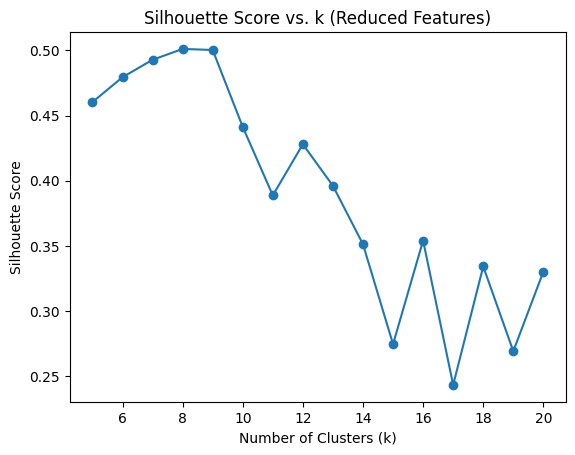

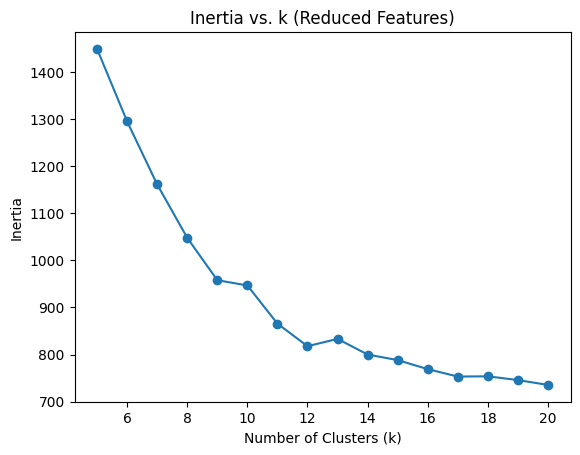

In [ ]:
import matplotlib.pyplot as plt



# Find best k
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"\nBest k: {best_k}, Silhouette Score: {max(silhouette_scores):.3f}")

# Plot silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k (Reduced Features)')
plt.show()

# Plot inertia
plt.plot(k_values, inertia_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia vs. k (Reduced Features)')
plt.show()

apply final clustering

In [ ]:
# 4.4 Final Clustering with Best k
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(job_features_reduced)
print("Clustering complete. Added 'cluster' column to DataFrame.")
print("Cluster distribution:")
print(df["cluster"].value_counts())

Clustering complete. Added 'cluster' column to DataFrame.
Cluster distribution:
cluster
2    1012
0     853
3     731
4     581
1     356
6     168
7     149
5     128
Name: count, dtype: int64


process userinput

In [ ]:

def preprocess_user_input(skills, salary, exp, location):
    # Skills to TF-IDF
    skills_clean = skills.lower().replace(", ", ",").strip()
    skills_vec = vectorizer.transform([skills_clean]).toarray()

    # Salary (assume LPA)
    salary_val = float(salary) if salary else df["salary_clean"].mean()
    salary_norm = salary_val / df["salary_clean"].max()

    # Experience
    exp_val = float(exp) if exp else df["exp_clean"].mean()
    exp_norm = exp_val / df["exp_clean"].max()

    # Location (one-hot for top 10)
    loc_clean = location.lower().strip()
    loc_vec = np.array([1 if loc_clean == loc else 0 for loc in top_locations]).reshape(1, -1)

    # Combine features
    user_features = np.hstack((skills_vec, [[salary_norm, exp_norm]], loc_vec))

    # Reduce with SVD
    user_features_reduced = svd.transform(user_features)
    return user_features_reduced



#  test with sample values
sample_skills = "java, spring boot, microservices"
sample_salary = "15"  # LPA
sample_exp = "4"      # years
sample_location = "hyderabad"
user_input = preprocess_user_input(sample_skills, sample_salary, sample_exp, sample_location)
print("User Features Reduced Shape:", user_input.shape)

User Features Reduced Shape: (1, 50)


assign user to cluster

In [ ]:
# 5.2.1 Assign User to Cluster (Revised)
# Reset df index to align with job_features_reduced
df = df.reset_index(drop=True)
print("DataFrame index reset. New shape:", df.shape)

# Find user's cluster
user_cluster = kmeans.predict(user_input)[0]
print(f"User assigned to Cluster: {user_cluster}")

# Filter jobs in user's cluster
cluster_jobs_idx = df[df["cluster"] == user_cluster].index
cluster_job_features = job_features_reduced[cluster_jobs_idx]
print(f"Number of jobs in Cluster {user_cluster}: {len(cluster_jobs_idx)}")

DataFrame index reset. New shape: (3978, 25)
User assigned to Cluster: 1
Number of jobs in Cluster 1: 356


knn recommendations

In [ ]:
from sklearn.neighbors import NearestNeighbors

# kNN for top 5 recommendations
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(cluster_job_features)
distances, indices = knn.kneighbors(user_input)
recommended_indices = cluster_jobs_idx[indices[0]]
recommendations = df.iloc[recommended_indices][["Title", "Tags", "Salary", "Location","Experience","job_link"]]
print("\nTop 5 Recommended Jobs:")
print(recommendations)


Top 5 Recommended Jobs:
                                                       Title  \
3259                             Java Microservice Developer   
588   Java Developer (Bangalore/Hyderabad/Pune/Chennai) -HKH   
600                                                Java Lead   
1202                               Java Developer-Pune (HKH)   
2912                                   Princ Engr-Full Stack   

                                                                                               Tags  \
3259                              java,cloud,j2ee,spring boot,microservices,development,boot,spring   
588                 java,hibernate,java development,j2ee,spring boot,microservices,boot,development   
600        java spring boot,java development,microservices,spring,spring boot,boot,development,java   
1202                                      java,hibernate,spring boot,j2ee,microservices,boot,spring   
2912  full stack development,java,nosql databases,postgresql,j2ee,spring bo

compute metrics

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Cosine similarity for recommendations
similarities = 1 - distances[0]  # Convert distance to similarity
avg_similarity = similarities.mean()
print(f"\nAverage Cosine Similarity: {avg_similarity:.3f}")

# Baseline: Random jobs from cluster
random_idx = np.random.choice(cluster_jobs_idx, 5, replace=False)
random_features = job_features_reduced[random_idx]
random_similarities = cosine_similarity(user_input, random_features)[0]
avg_random_similarity = random_similarities.mean()
print(f"Random Baseline Similarity: {avg_random_similarity:.3f}")


Average Cosine Similarity: 0.960
Random Baseline Similarity: 0.742


plots for paper

1.silhouette score vs k plt

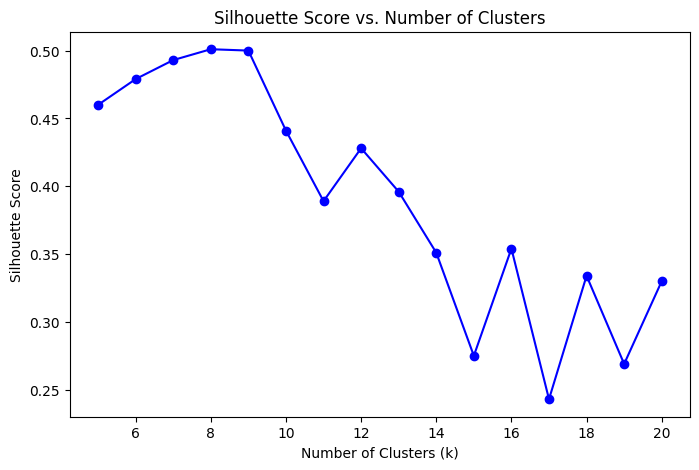

In [ ]:
import matplotlib.pyplot as plt


k_values = range(5, 21)
silhouette_scores = [0.460, 0.479, 0.493, 0.501, 0.500, 0.441, 0.389, 0.428, 0.396, 0.351, 0.275, 0.354, 0.243, 0.334, 0.269, 0.330]

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.savefig("silhouette_score_plot.png", dpi=300, format="png", bbox_inches='tight')

plt.show()


2.Inertia vs k plot

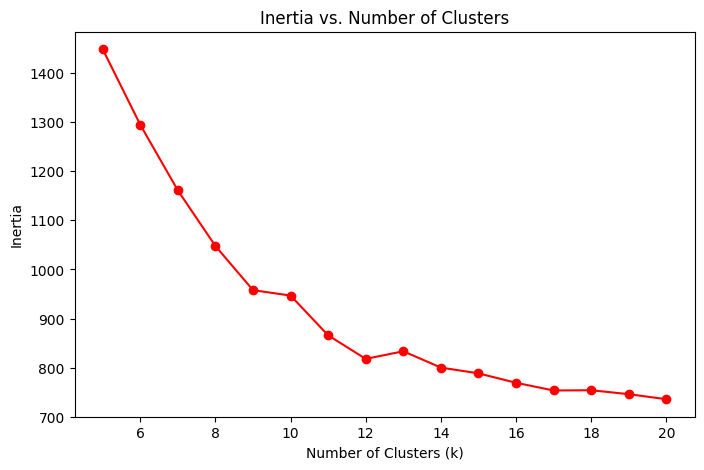

In [ ]:

inertia_scores = [1448.8, 1294.8, 1161.0, 1047.7, 957.8, 946.7, 865.7, 817.7, 833.2, 800.0, 788.2, 769.0, 753.3, 753.8, 745.8, 735.5]

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia vs. Number of Clusters')
plt.savefig("Linertiavscluster_plot.png", dpi=300, format="png", bbox_inches='tight')
plt.show()

3.cluster Distribution Barchart

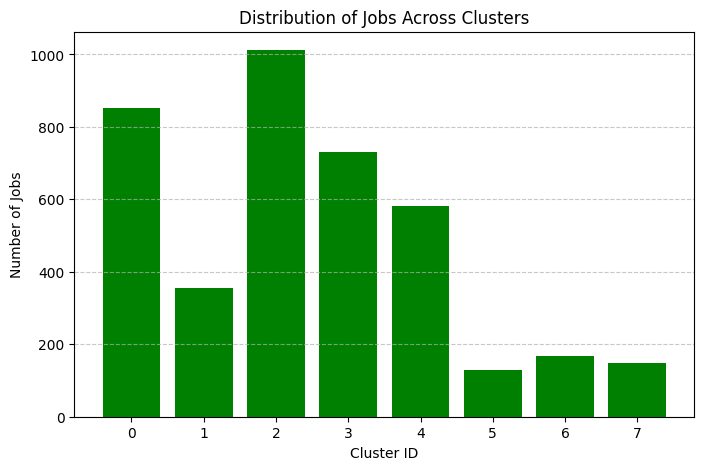

In [ ]:
import matplotlib.pyplot as plt


cluster_counts = df["cluster"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color='g')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Jobs')
plt.title('Distribution of Jobs Across Clusters')
plt.xticks(range(8))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("Ldistribution_plot.png", dpi=300, format="png", bbox_inches='tight')
plt.show()

4.cosine similarity bar chart

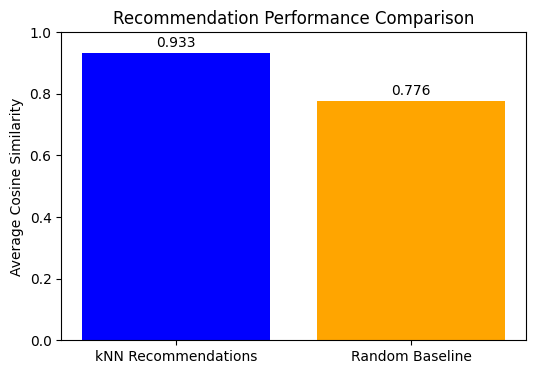

In [ ]:
import matplotlib.pyplot as plt

metrics = [0.933, 0.776]
labels = ['kNN Recommendations', 'Random Baseline']

plt.figure(figsize=(6, 4))
plt.bar(labels, metrics, color=['b', 'orange'])
plt.ylabel('Average Cosine Similarity')
plt.title('Recommendation Performance Comparison')
plt.ylim(0, 1)
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.savefig("Lcomparison.png", dpi=300, format="png", bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np


print("Job Features Shape:", job_features.shape)

# 1. K-means (k=8 for consistency)
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(job_features)
kmeans_silhouette = silhouette_score(job_features, kmeans_labels)
print(f"K-means (k=8): Silhouette Score = {kmeans_silhouette:.3f}")

# 2. DBSCAN (tune eps for reasonable clusters)
dbscan = DBSCAN(eps=1.0, min_samples=5)  # eps=1.0 to start, adjust if needed
dbscan_labels = dbscan.fit_predict(job_features)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  # Exclude noise
if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(job_features, dbscan_labels)
    print(f"DBSCAN: {n_clusters_dbscan} clusters, Silhouette Score = {dbscan_silhouette:.3f}")
else:
    print(f"DBSCAN: {n_clusters_dbscan} clusters (insufficient for silhouette)")

# 3. Hierarchical Clustering (k=8)
hierarchical = AgglomerativeClustering(n_clusters=8)
hierarchical_labels = hierarchical.fit_predict(job_features)
hierarchical_silhouette = silhouette_score(job_features, hierarchical_labels)
print(f"Hierarchical (k=8): Silhouette Score = {hierarchical_silhouette:.3f}")

# 4. Gaussian Mixture Model (k=8)
gmm = GaussianMixture(n_components=8, random_state=42)
gmm_labels = gmm.fit_predict(job_features)
gmm_silhouette = silhouette_score(job_features, gmm_labels)
print(f"GMM (k=8): Silhouette Score = {gmm_silhouette:.3f}")


scores = {
    "K-means": kmeans_silhouette,
    "Hierarchical": hierarchical_silhouette,
    "GMM": gmm_silhouette
}
if n_clusters_dbscan > 1:
    scores["DBSCAN"] = dbscan_silhouette
best_algo = max(scores, key=scores.get)
print(f"\nBest Algorithm on Full Features: {best_algo}, Silhouette Score = {scores[best_algo]:.3f}")

Job Features Shape: (3978, 5383)
K-means (k=8): Silhouette Score = 0.219
DBSCAN: 35 clusters, Silhouette Score = -0.188
Hierarchical (k=8): Silhouette Score = 0.218
GMM (k=8): Silhouette Score = 0.159

Best Algorithm on Full Features: K-means, Silhouette Score = 0.219


In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import numpy as np


if 'job_features_reduced' not in globals():
    svd = TruncatedSVD(n_components=50, random_state=42)
    job_features_reduced = svd.fit_transform(job_features)
print("Reduced Features Shape:", job_features_reduced.shape)

# 1. K-means (k=8)
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(job_features_reduced)
kmeans_silhouette = silhouette_score(job_features_reduced, kmeans_labels)
print(f"K-means (k=8): Silhouette Score = {kmeans_silhouette:.3f}")

# 2. DBSCAN (tune eps)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps=0.5 from earlier, adjust if needed
dbscan_labels = dbscan.fit_predict(job_features_reduced)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(job_features_reduced, dbscan_labels)
    print(f"DBSCAN: {n_clusters_dbscan} clusters, Silhouette Score = {dbscan_silhouette:.3f}")
else:
    print(f"DBSCAN: {n_clusters_dbscan} clusters (insufficient for silhouette)")

# 3. Hierarchical (k=8)
hierarchical = AgglomerativeClustering(n_clusters=8)
hierarchical_labels = hierarchical.fit_predict(job_features_reduced)
hierarchical_silhouette = silhouette_score(job_features_reduced, hierarchical_labels)
print(f"Hierarchical (k=8): Silhouette Score = {hierarchical_silhouette:.3f}")

# 4. GMM (k=8)
gmm = GaussianMixture(n_components=8, random_state=42)
gmm_labels = gmm.fit_predict(job_features_reduced)
gmm_silhouette = silhouette_score(job_features_reduced, gmm_labels)
print(f"GMM (k=8): Silhouette Score = {gmm_silhouette:.3f}")


scores = {
    "K-means": kmeans_silhouette,
    "Hierarchical": hierarchical_silhouette,
    "GMM": gmm_silhouette
}
if n_clusters_dbscan > 1:
    scores["DBSCAN"] = dbscan_silhouette
best_algo = max(scores, key=scores.get)
print(f"\nBest Algorithm on Reduced Features: {best_algo}, Silhouette Score = {scores[best_algo]:.3f}")

# Update clusters with best algorithm
if best_algo == "GMM":
    df["cluster"] = gmm_labels
elif best_algo == "Hierarchical":
    df["cluster"] = hierarchical_labels
elif best_algo == "DBSCAN" and n_clusters_dbscan > 1:
    df["cluster"] = dbscan_labels
else:
    df["cluster"] = kmeans_labels
print("Cluster distribution:")
print(df["cluster"].value_counts())

Reduced Features Shape: (3978, 50)
K-means (k=8): Silhouette Score = 0.501
DBSCAN: 11 clusters, Silhouette Score = 0.423
Hierarchical (k=8): Silhouette Score = 0.501
GMM (k=8): Silhouette Score = 0.376

Best Algorithm on Reduced Features: K-means, Silhouette Score = 0.501
Cluster distribution:
cluster
2    1012
0     853
3     731
4     581
1     356
6     168
7     149
5     128
Name: count, dtype: int64


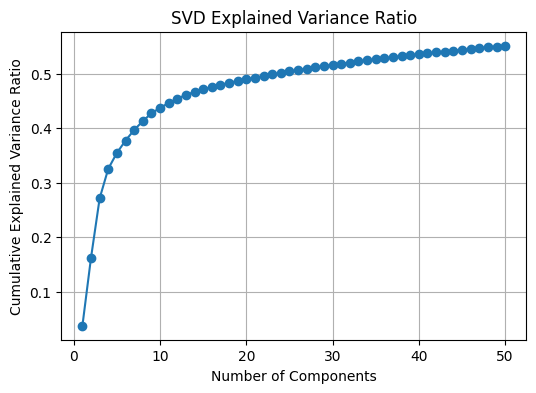

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import numpy as np
svd = TruncatedSVD(n_components=50, random_state=42)
svd.fit(job_features)
variance_ratio = np.cumsum(svd.explained_variance_ratio_)
plt.figure(figsize=(6, 4))
plt.plot(range(1, 51), variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('SVD Explained Variance Ratio')
plt.savefig("Lsvd.png", dpi=300, format="png", bbox_inches='tight')
plt.grid(True)
plt.show()